# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups        
Sample_087  Q9ULB4                   12.826
Sample_018  P15151-2                 15.484
Sample_025  G3V3X5;G3V511;Q14767     16.780
Sample_086  A6NCT7;Q07092;Q07092-2   15.251
Sample_208  Q96JF0                   16.932
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups        
Sample_099  Q9Y490                   12.615
Sample_109  Q13332-5                 15.467
Sample_144  J3KSJ8;Q9UD71;Q9UD71-2   11.688
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.956
            A0A075B6Q5                 13.873
            A0A075B6R2                 12.713
            A0A075B6S5                 13.221
            A0A087WSY4                 12.752
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.876
            Q9UI40;Q9UI40-2            13.367
            Q9UIW2                     11.940
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.595
            Q9UP79                     11.633
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.196,15.050,16.842,19.863,15.719,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.756,19.067,...,15.528,15.576,14.150,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.817,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.608,17.705,17.039,16.072,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.725,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.275,15.345,17.084,18.708,14.249,19.433,11.392,11.088
Sample_207,15.739,16.877,15.469,16.898,14.680,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.351,12.343,11.991,13.056,11.776,13.090,13.366,11.845,12.653,13.398
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.896,19.067,16.127,...,13.524,13.011,12.359,13.362,13.986,13.333,14.119,12.244,12.224,13.234
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.187,12.705,12.104,12.180,13.027,12.834,12.166,13.774,11.934,11.806
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,13.377,12.848,13.468,11.583,13.528,12.697,12.880,13.019,12.530,13.168
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,12.926,12.978,13.931,11.395,12.598,13.858,13.437,13.283,13.024,12.744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.721,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 319.57it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  8.82it/s]

100%|██████████| 2/2 [00:00<00:00,  8.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.82it/s]

100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

100%|██████████| 3/3 [00:00<00:00,  6.17it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.77it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.79it/s]

100%|██████████| 4/4 [00:01<00:00,  3.39it/s]

100%|██████████| 4/4 [00:01<00:00,  3.68it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  7.01it/s]

 60%|██████    | 3/5 [00:00<00:00,  5.46it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.84it/s]

100%|██████████| 5/5 [00:00<00:00,  4.74it/s]

100%|██████████| 5/5 [00:00<00:00,  5.04it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.44it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.56it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.88it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.30it/s]

100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

100%|██████████| 6/6 [00:01<00:00,  3.66it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.71it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.77it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.61it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.26it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.10it/s]

100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  8.25it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.71it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.29it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.06it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.83it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.86it/s]

100%|██████████| 8/8 [00:01<00:00,  3.93it/s]

100%|██████████| 8/8 [00:01<00:00,  4.24it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.53it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.29it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.92it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.81it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.88it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.60it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.22it/s]

100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.92it/s]

 30%|███       | 3/10 [00:00<00:01,  4.36it/s]

 40%|████      | 4/10 [00:00<00:01,  4.15it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.08it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.19it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.02it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.50it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.53it/s]

100%|██████████| 10/10 [00:02<00:00,  3.45it/s]

100%|██████████| 10/10 [00:02<00:00,  3.85it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.55it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.29it/s]

 36%|███▋      | 4/11 [00:00<00:01,  3.68it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.82it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.89it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.83it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.53it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.53it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.58it/s]

100%|██████████| 11/11 [00:02<00:00,  3.77it/s]

100%|██████████| 11/11 [00:02<00:00,  3.84it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  8.76it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.44it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.73it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.91it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.71it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.39it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.52it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.75it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.67it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.69it/s]

100%|██████████| 12/12 [00:03<00:00,  3.65it/s]

100%|██████████| 12/12 [00:03<00:00,  3.93it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  8.85it/s]

 23%|██▎       | 3/13 [00:00<00:01,  6.20it/s]

 31%|███       | 4/13 [00:00<00:01,  5.05it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.78it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.77it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.70it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.87it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.44it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.22it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.05it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.02it/s]

100%|██████████| 13/13 [00:03<00:00,  3.15it/s]

100%|██████████| 13/13 [00:03<00:00,  3.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.62it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.28it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.71it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.45it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.47it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.35it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.41it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.72it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.27it/s]

 79%|███████▊  | 11/14 [00:02<00:01,  2.90it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.88it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.86it/s]

100%|██████████| 14/14 [00:03<00:00,  3.02it/s]

100%|██████████| 14/14 [00:03<00:00,  3.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.68it/s]

 20%|██        | 3/15 [00:00<00:01,  6.07it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.22it/s]

 33%|███▎      | 5/15 [00:00<00:02,  4.63it/s]

 40%|████      | 6/15 [00:01<00:01,  4.56it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.49it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.49it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.61it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  4.04it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.48it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.32it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  2.97it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  2.79it/s]

100%|██████████| 15/15 [00:04<00:00,  2.78it/s]

100%|██████████| 15/15 [00:04<00:00,  3.68it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.005      0.053 0.021          0.856 0.239       0.155   
2             0.004 0.004      0.060 0.026          0.680 0.121       0.533   
3             0.004 0.004      0.051 0.017          0.695 0.114       0.635   
4             0.005 0.005      0.043 0.017          0.720 0.080       0.722   
5             0.005 0.005      0.046 0.020          0.764 0.085       0.736   
6             0.004 0.002      0.039 0.009          0.760 0.094       0.749   
7             0.004 0.003      0.046 0.019          0.769 0.096       0.750   
8             0.004 0.002      0.038 0.010          0.807 0.089       0.825   
9             0.004 0.002      0.038 0.010          0.797 0.091       0.819   
10            0.004 0.002      0.039 0.010          0.796 0.095       0.801   
11            0.004 0.003      0.034 0.007          0.800 0.091       0.816   
12            0.005 0.005      0.040 0.012          0.808 0.081       0.821   
13            0.005 0.004      0.043 0.015          0.797 0.084       0.819   
14            0.005 0.004      0.042 0.013          0.796 0.086       0.814   
15            0.004 0.002      0.037 0.010          0.788 0.086       0.806   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.091   0.254 0.128                  0.570 0.045        0.861   
2          0.109   0.590 0.091                  0.670 0.066        0.727   
3          0.132   0.654 0.096                  0.710 0.075        0.795   
4          0.112   0.716 0.080                  0.757 0.066        0.842   
5          0.102   0.745 0.075                  0.783 0.062        0.856   
6          0.117   0.748 0.079                  0.786 0.066        0.852   
7          0.116   0.753 0.079                  0.790 0.066        0.851   
8          0.085   0.811 0.057                  0.837 0.049        0.896   
9          0.099   0.802 0.067                  0.831 0.057        0.895   
10         0.106   0.793 0.075                  0.823 0.063        0.894   
11         0.105   0.803 0.074                  0.832 0.063        0.897   
12         0.102   0.810 0.070                  0.838 0.058        0.906   
13         0.098   0.804 0.072                  0.832 0.061        0.906   
14         0.099   0.801 0.071                  0.829 0.060        0.905   
15         0.095   0.793 0.066                  0.822 0.057        0.904   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.830 0.092        210.000 0.000  
2          0.083                  0.670 0.102        210.000 0.000  
3          0.076                  0.724 0.098        210.000 0.000  
4          0.061                  0.791 0.084        210.000 0.000  
5          0.060                  0.817 0.083        210.000 0.000  
6          0.057                  0.808 0.081        210.000 0.000  
7          0.057                  0.808 0.079        210.000 0.000  
8          0.049                  0.872 0.063        210.000 0.000  
9          0.051                  0.872 0.060        210.000 0.000  
10         0.052                  0.869 0.063        210.000 0.000  
11         0.051                  0.875 0.061        210.000 0.000  
12         0.050                  0.892 0.056        210.000 0.000  
13         0.049                  0.894 0.052        210.000 0.000  
14         0.049                  0.893 0.052        210.000 0.000  
15         0.049                  0.891 0.054 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 506.93it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.87it/s]

100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.84it/s]

100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

100%|██████████| 3/3 [00:00<00:00,  3.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.62it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.91it/s]

100%|██████████| 4/4 [00:01<00:00,  3.77it/s]

100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.08it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.40it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.16it/s]

100%|██████████| 5/5 [00:01<00:00,  3.31it/s]

100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.95it/s]

 50%|█████     | 3/6 [00:00<00:00,  6.36it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.16it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.62it/s]

100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

100%|██████████| 6/6 [00:01<00:00,  3.89it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.61it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.64it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.32it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.28it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.98it/s]

100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

100%|██████████| 7/7 [00:02<00:00,  3.42it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.65it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.80it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.00it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.23it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.49it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.04it/s]

100%|██████████| 8/8 [00:02<00:00,  2.74it/s]

100%|██████████| 8/8 [00:02<00:00,  3.48it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.86it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.28it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.90it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.78it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.86it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.08it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.90it/s]

100%|██████████| 9/9 [00:03<00:00,  2.81it/s]

100%|██████████| 9/9 [00:03<00:00,  2.97it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.37it/s]

 30%|███       | 3/10 [00:00<00:01,  4.67it/s]

 40%|████      | 4/10 [00:00<00:01,  3.99it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.08it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.74it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.34it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.09it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.93it/s]

100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

100%|██████████| 10/10 [00:03<00:00,  3.28it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.25it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.05it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.72it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.74it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.79it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.57it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.69it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.70it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.72it/s]

100%|██████████| 11/11 [00:02<00:00,  3.41it/s]

100%|██████████| 11/11 [00:02<00:00,  3.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  7.67it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.15it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.54it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.40it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.24it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.18it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.53it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.10it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  2.82it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.74it/s]

100%|██████████| 12/12 [00:03<00:00,  2.32it/s]

100%|██████████| 12/12 [00:03<00:00,  3.20it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.32it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.67it/s]

 31%|███       | 4/13 [00:01<00:02,  3.65it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.56it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.36it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.19it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.27it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.30it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.47it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.52it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.34it/s]

100%|██████████| 13/13 [00:03<00:00,  2.98it/s]

100%|██████████| 13/13 [00:03<00:00,  3.32it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.70it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.76it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.40it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.15it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.97it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.94it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.96it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.90it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.87it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.80it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.36it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  2.89it/s]

100%|██████████| 14/14 [00:03<00:00,  2.65it/s]

100%|██████████| 14/14 [00:04<00:00,  3.50it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.55it/s]

 20%|██        | 3/15 [00:00<00:02,  4.38it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.69it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.61it/s]

 40%|████      | 6/15 [00:01<00:02,  3.55it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.09it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.94it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.73it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.94it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.96it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.12it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.23it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  3.20it/s]

100%|██████████| 15/15 [00:04<00:00,  3.34it/s]

100%|██████████| 15/15 [00:04<00:00,  3.29it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.034 0.007          0.108 0.283       0.012   
2             0.003 0.002      0.047 0.018          0.751 0.125       0.631   
3             0.005 0.006      0.049 0.021          0.752 0.096       0.678   
4             0.003 0.002      0.035 0.009          0.754 0.096       0.675   
5             0.003 0.003      0.031 0.013          0.740 0.102       0.678   
6             0.004 0.003      0.042 0.017          0.746 0.095       0.681   
7             0.005 0.004      0.039 0.014          0.747 0.104       0.702   
8             0.004 0.002      0.044 0.018          0.748 0.103       0.700   
9             0.005 0.004      0.055 0.024          0.763 0.095       0.749   
10            0.005 0.004      0.052 0.022          0.778 0.098       0.755   
11            0.007 0.005      0.063 0.019          0.792 0.088       0.794   
12            0.005 0.005      0.051 0.025          0.797 0.092       0.796   
13            0.005 0.004      0.063 0.021          0.798 0.090       0.796   
14            0.005 0.004      0.056 0.027          0.798 0.086       0.786   
15            0.004 0.003      0.038 0.014          0.794 0.086       0.797   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.034   0.021 0.057                  0.502 0.015        0.862   
2          0.122   0.676 0.092                  0.733 0.072        0.795   
3          0.113   0.708 0.085                  0.756 0.065        0.855   
4          0.109   0.707 0.083                  0.756 0.064        0.852   
5          0.134   0.700 0.096                  0.750 0.075        0.873   
6          0.135   0.705 0.094                  0.754 0.073        0.872   
7          0.133   0.717 0.101                  0.763 0.081        0.877   
8          0.135   0.717 0.100                  0.763 0.079        0.874   
9          0.121   0.752 0.093                  0.789 0.078        0.890   
10         0.124   0.762 0.097                  0.798 0.080        0.889   
11         0.112   0.788 0.079                  0.820 0.067        0.914   
12         0.111   0.792 0.082                  0.822 0.070        0.916   
13         0.111   0.793 0.082                  0.823 0.070        0.916   
14         0.106   0.788 0.079                  0.819 0.066        0.920   
15         0.107   0.791 0.078                  0.822 0.066        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.829 0.087        210.000 0.000  
2          0.074                  0.736 0.094        210.000 0.000  
3          0.059                  0.820 0.072        210.000 0.000  
4          0.059                  0.819 0.071        210.000 0.000  
5          0.053                  0.841 0.065        210.000 0.000  
6          0.055                  0.842 0.064        210.000 0.000  
7          0.058                  0.846 0.069        210.000 0.000  
8          0.060                  0.843 0.070        210.000 0.000  
9          0.057                  0.868 0.066        210.000 0.000  
10         0.055                  0.865 0.066        210.000 0.000  
11         0.048                  0.892 0.055        210.000 0.000  
12         0.048                  0.897 0.054        210.000 0.000  
13         0.047                  0.897 0.054        210.000 0.000  
14         0.045                  0.900 0.054        210.000 0.000  
15         0.044                  0.899 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1243.86it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 38.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 21.75it/s]

100%|██████████| 3/3 [00:00<00:00, 21.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.18it/s]

100%|██████████| 4/4 [00:00<00:00, 17.32it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 24.26it/s]

100%|██████████| 5/5 [00:00<00:00, 19.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 21.50it/s]

100%|██████████| 6/6 [00:00<00:00, 15.20it/s]

100%|██████████| 6/6 [00:00<00:00, 15.14it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 24.18it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 18.25it/s]

100%|██████████| 7/7 [00:00<00:00, 18.15it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00, 19.21it/s]

 50%|█████     | 4/8 [00:00<00:00, 16.15it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 13.92it/s]

100%|██████████| 8/8 [00:00<00:00, 12.87it/s]

100%|██████████| 8/8 [00:00<00:00, 13.50it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 22.00it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 17.76it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.98it/s]

100%|██████████| 9/9 [00:00<00:00, 17.36it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 23.52it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.30it/s]

 80%|████████  | 8/10 [00:00<00:00, 17.46it/s]

100%|██████████| 10/10 [00:00<00:00, 16.07it/s]

100%|██████████| 10/10 [00:00<00:00, 16.59it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 17.53it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.94it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 14.15it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 14.73it/s]

100%|██████████| 11/11 [00:00<00:00, 14.25it/s]

100%|██████████| 11/11 [00:00<00:00, 14.76it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 25.17it/s]

 50%|█████     | 6/12 [00:00<00:00, 19.32it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 15.94it/s]

100%|██████████| 12/12 [00:00<00:00, 17.38it/s]

100%|██████████| 12/12 [00:00<00:00, 17.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 24.78it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.19it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 15.95it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.24it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 14.82it/s]

100%|██████████| 13/13 [00:00<00:00, 15.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 23.95it/s]

 43%|████▎     | 6/14 [00:00<00:00, 17.83it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.98it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 13.85it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.80it/s]

100%|██████████| 14/14 [00:00<00:00, 14.78it/s]

100%|██████████| 14/14 [00:00<00:00, 15.03it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 22.57it/s]

 40%|████      | 6/15 [00:00<00:00, 17.25it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 18.11it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 18.07it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 19.57it/s]

100%|██████████| 15/15 [00:00<00:00, 18.69it/s]

100%|██████████| 15/15 [00:00<00:00, 18.68it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.003      0.046 0.021          0.000 0.000       0.000   
2             0.004 0.003      0.039 0.015          0.596 0.127       0.360   
3             0.004 0.002      0.038 0.010          0.616 0.099       0.473   
4             0.004 0.003      0.046 0.016          0.644 0.113       0.512   
5             0.004 0.002      0.034 0.007          0.641 0.113       0.500   
6             0.005 0.005      0.046 0.019          0.648 0.115       0.502   
7             0.003 0.000      0.036 0.009          0.646 0.113       0.505   
8             0.005 0.004      0.045 0.015          0.650 0.108       0.508   
9             0.004 0.002      0.038 0.012          0.668 0.099       0.571   
10            0.005 0.004      0.052 0.020          0.667 0.103       0.570   
11            0.004 0.002      0.038 0.012          0.657 0.105       0.560   
12            0.005 0.004      0.046 0.020          0.690 0.100       0.598   
13            0.005 0.006      0.051 0.023          0.688 0.089       0.620   
14            0.006 0.006      0.050 0.019          0.707 0.097       0.669   
15            0.008 0.008      0.069 0.023          0.699 0.099       0.650   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.751   
2          0.081   0.444 0.084                  0.588 0.058        0.672   
3          0.099   0.529 0.082                  0.627 0.057        0.714   
4          0.095   0.563 0.078                  0.647 0.061        0.735   
5          0.109   0.555 0.092                  0.645 0.067        0.740   
6          0.104   0.558 0.086                  0.648 0.063        0.736   
7          0.107   0.559 0.089                  0.648 0.065        0.728   
8          0.101   0.564 0.086                  0.652 0.062        0.723   
9          0.113   0.607 0.080                  0.677 0.061        0.776   
10         0.110   0.605 0.080                  0.675 0.061        0.773   
11         0.114   0.595 0.086                  0.668 0.064        0.770   
12         0.114   0.632 0.086                  0.697 0.063        0.785   
13         0.105   0.646 0.077                  0.705 0.059        0.788   
14         0.108   0.681 0.080                  0.729 0.067        0.804   
15         0.108   0.667 0.078                  0.719 0.065        0.799   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.069                  0.695 0.087        210.000 0.000  
2          0.070                  0.639 0.078        210.000 0.000  
3          0.066                  0.677 0.070        210.000 0.000  
4          0.067                  0.690 0.077        210.000 0.000  
5          0.069                  0.695 0.084        210.000 0.000  
6          0.068                  0.695 0.084        210.000 0.000  
7          0.065                  0.688 0.080        210.000 0.000  
8          0.066                  0.684 0.078        210.000 0.000  
9          0.061                  0.730 0.077        210.000 0.000  
10         0.062                  0.724 0.081        210.000 0.000  
11         0.062                  0.720 0.080        210.000 0.000  
12         0.060                  0.732 0.081        210.000 0.000  
13         0.059                  0.739 0.080        210.000 0.000  
14         0.058                  0.751 0.079        210.000 0.000  
15         0.060                  0.748 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,1,11,15
score_time,2,11,15
test_precision,1,14,14
test_recall,8,15,14
test_f1,8,13,14
test_balanced_accuracy,12,13,14
test_roc_auc,13,14,14
test_average_precision,13,14,14
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.09it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.79it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.20it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.78it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.47it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.29it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.28it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.25it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.29it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.39it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.56it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.65it/s]

100%|██████████| 14/14 [00:05<00:00,  2.86it/s]

100%|██████████| 14/14 [00:05<00:00,  2.71it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 24.89it/s]

 43%|████▎     | 6/14 [00:00<00:00, 19.09it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 16.99it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 16.30it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 17.32it/s]

100%|██████████| 14/14 [00:00<00:00, 16.20it/s]

100%|██████████| 14/14 [00:00<00:00, 17.11it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.81it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.64it/s]

 31%|███       | 4/13 [00:00<00:02,  4.22it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.21it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.30it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.07it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.08it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.56it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.66it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.71it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.60it/s]

100%|██████████| 13/13 [00:02<00:00,  4.60it/s]

100%|██████████| 13/13 [00:02<00:00,  4.49it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


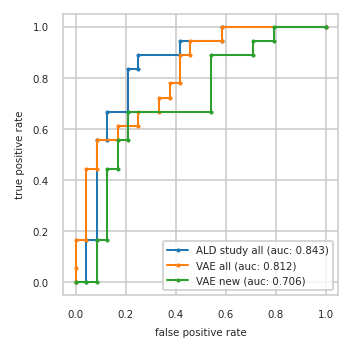

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.167   0.000 0.167   0.083 0.000
3          0.083 0.167   0.042 0.167   0.083 0.167
4          0.083 0.556   0.042 0.444   0.125 0.167
5          0.125 0.556   0.083 0.444   0.125 0.444
6          0.125 0.667   0.083 0.556   0.167 0.444
7          0.208 0.667   0.167 0.556   0.167 0.556
8          0.208 0.833   0.167 0.611   0.208 0.556
9          0.250 0.833   0.250 0.611   0.208 0.667
10         0.250 0.889   0.250 0.667   0.542 0.667
11         0.417 0.889   0.333 0.667   0.542 0.889
12         0.417 0.944   0.333 0.722   0.708 0.889
13         0.583 0.944   0.375 0.722   0.708 0.944
14         0.583 1.000   0.375 0.778   0.792 0.944
15         1.000 1.000   0.417 0.778   0.792 1.000
16           NaN   NaN   0.417 0.889   1.000 1.000
17           NaN   NaN   0.458 0.889     NaN   NaN
18           NaN   NaN   0.458 0.944     NaN   NaN
19           NaN   NaN   0.583 0.944     NaN   NaN
20           NaN   NaN   0.583 1.000     NaN   NaN
21           NaN   NaN   1.000 1.000     NaN   NaN

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,P02766,Q9UMX0;Q9UMX0-2;Q9UMX0-4
2,P09486,P08670,P23560;P23560-2;P23560-3;P23560-4;P23560-5
3,K7ERG9;P00746,Q9Y2T3;Q9Y2T3-3,P31321
4,P14174,P61981,P51688
5,P10636-2;P10636-6,P14174,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
6,P61981,P04075,J3KSJ8;Q9UD71;Q9UD71-2
7,Q6EMK4,Q14894,Q96GD0
8,Q9Y2T3;Q9Y2T3-3,P63104,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


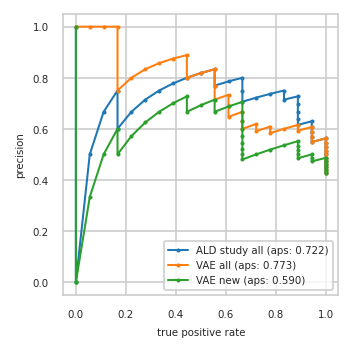

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.500 0.889
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.552 0.889
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.615 0.889     0.615 0.889     0.500 0.722
17         0.640 0.889     0.600 0.833     0.480 0.667
18         0.667 0.889     0.583 0.778     0.500 0.667
19         0.696 0.889     0.609 0.778     0.522 0.667
20         0.727 0.889     0.591 0.722     0.545 0.667
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.750 0.833     0.600 0.667     0.600 0.667
23         0.737 0.778     0.632 0.667     0.632 0.667
24         0.722 0.722     0.667 0.667     0.667 0.667
25         0.706 0.667     0.647 0.611     0.706 0.667
26         0.750 0.667     0.688 0.611     0.688 0.611
27         0.800 0.667     0.733 0.611     0.667 0.556
28         0.786 0.611     0.714 0.556     0.714 0.556
29         0.769 0.556     0.769 0.556     0.692 0.500
30         0.833 0.556     0.833 0.556     0.667 0.444
31         0.818 0.500     0.818 0.500     0.727 0.444
32         0.800 0.444     0.800 0.444     0.700 0.389
33         0.778 0.389     0.889 0.444     0.667 0.333
34         0.750 0.333     0.875 0.389     0.625 0.278
35         0.714 0.278     0.857 0.333     0.571 0.222
36         0.667 0.222     0.833 0.278     0.500 0.167
37         0.600 0.167     0.800 0.222     0.600 0.167
38         0.750 0.167     0.750 0.167     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


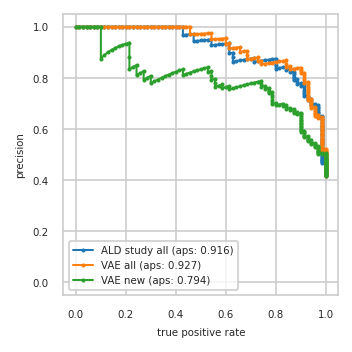

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


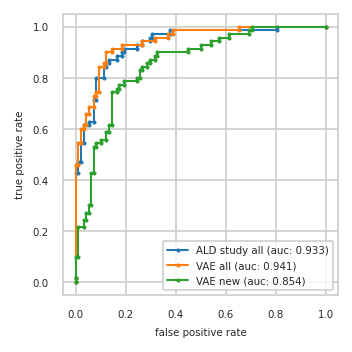

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}